# SVM - Mejor separación por TSNE

En este notebook se buscará la mejor combinación de atributos de forma tal que generen un patrón observable con TSNE.

#### Bibliotecas

In [1]:
# Modelo
from sklearn.svm import SVC

# Preprocessing
import utils
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import roc_curve, plot_roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Plots
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# No supervisado
from sklearn.manifold import TSNE

In [2]:
df = utils.feature_engineering(utils.get_data())

In [3]:
def dejar_variables_continuas(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad', 'horas_trabajo_registradas']].copy()

In [4]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=112)

### 1) Análisis sólo de variables continuas

In [5]:
scaler1 = MinMaxScaler(feature_range=(0,1))

X_train1 = pd.DataFrame(scaler1.fit_transform(dejar_variables_continuas(X_train)))
X_test1 = pd.DataFrame(scaler1.transform(dejar_variables_continuas(X_test)))

In [7]:
X_tsne = TSNE(n_components=2, perplexity=100, learning_rate=400, n_iter_without_progress=500, n_jobs=-1, verbose=4).fit_transform(X_train1)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.146s...
[t-SNE] Computed neighbors for 24420 samples in 1.594s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for sa

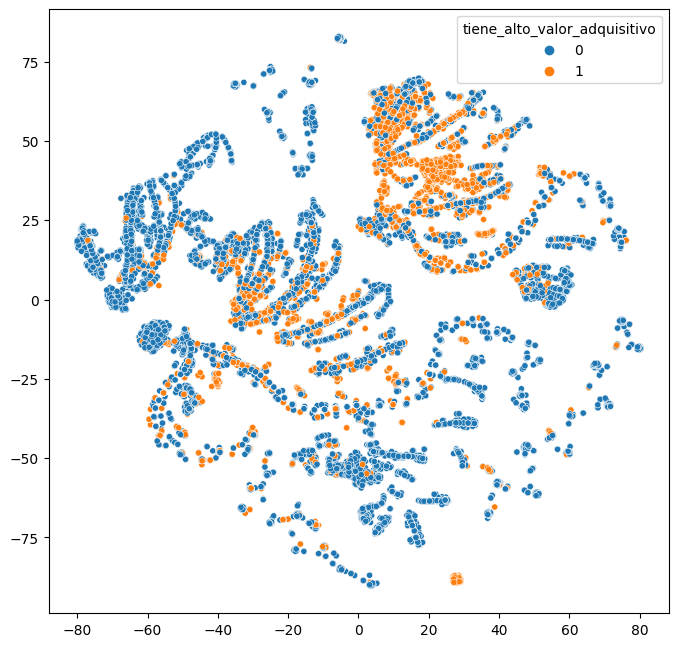

In [9]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=20
)

plt.show()

Podemos ver que la separación no es mala, se puede llegar a un modelo decente entrenando un SVM

### Entrenando el primer modelo

In [11]:
params = [{'kernel': ['linear'], 'C': np.logspace(-3, 2, 6)},
          {'kernel': ['poly'], 'C': np.logspace(-3, 2, 6), 'degree': range(2, 4)},
          {'kernel': ['rbf'], 'C': np.logspace(-3, 2, 6) ,'gamma': [0.01, 0.001, 0.0001]}
         ]
model = SVC()

gscv1 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=6, verbose = 4, cv=5)

In [71]:
%%time
gscv1.fit(X_train1, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   33.9s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  7.8min
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed: 20.2min finished


CPU times: user 9min 3s, sys: 643 ms, total: 9min 3s
Wall time: 29min 16s


GridSearchCV(cv=5, estimator=SVC(), n_jobs=6,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['linear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'degree': range(2, 4), 'kernel': ['poly']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='roc_auc', verbose=4)

### El mejor modelo:

In [87]:
print(gscv1.best_estimator_)
print(gscv1.best_params_)
print(gscv1.best_score_)

SVC(C=100.0, kernel='poly')
{'C': 100.0, 'degree': 3, 'kernel': 'poly'}
0.845228957392133


##### Observaciones

Los mejores modelos se obtuvieron con un kernel polinómico de grado 3... por mucho superiores a los demás kernels, lo mejor será elegir un C similar al obtenido para el mejor de grado 3 y seguir probando con polinomios de mayor orden.

In [94]:
gscv1.cv_results_

{'mean_fit_time': array([  8.71375813,  11.16395311,  11.52420287,  12.0144938 ,
         16.48273082,  75.35419245,   7.21978579,  10.35267949,
          9.95198026,  12.29559202,  11.87093592,  13.09892321,
         15.08375087,  25.71390147,  31.47045698, 105.04646883,
        111.21768599, 705.01004105,   9.19617963,   9.5313343 ,
          8.58990393,   9.27688875,   9.00481181,   8.97303104,
         10.72479277,  10.12377958,   8.38229055,  10.6140368 ,
         11.76341929,  10.69462109,  12.92453828,  11.59022255,
         12.33325787,  12.65302052,  12.6587707 ,  11.8534328 ]),
 'std_fit_time': array([ 0.45080598,  0.90351916,  0.64299743,  0.97676041,  1.25017814,
         3.66262592,  1.08269455,  2.03329831,  1.68537051,  1.25781552,
         0.50810614,  1.11128993,  0.41403375,  1.70526566,  5.55963124,
         7.10226101,  8.08168516, 62.10984821,  0.54537765,  0.70023946,
         0.48521863,  0.7180118 ,  0.85579947,  0.20442649,  0.95932281,
         0.57457128,  0.

In [109]:
print(classification_report(y_test,gscv1.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.81      0.98      0.89      6182
           1       0.83      0.28      0.42      1959

    accuracy                           0.81      8141
   macro avg       0.82      0.63      0.66      8141
weighted avg       0.82      0.81      0.78      8141



Podemos ver que se obtienen valores regulares. Un accuracy del 81% es regular. Además el recall de 1s es pésimo.

Por lo cual, considero que la selección de variables fue un tanto "pobre". Veamos con otras combinaciones.

### Las primeras variables continuas utilizadas en un árbol de decisión

La idea es ver con el árbol de decisión aquellas variables que mejor "dividen" el espacio para predecir, por ende usaremos un árbol para ver qué nodos tomó en cada nivel.


In [6]:
from sklearn.tree import DecisionTreeClassifier

import graphviz
import dtreeviz.trees as dtreeviz

In [7]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth=3)
arbol.fit(X_train1, y_train)

DecisionTreeClassifier(max_depth=3)

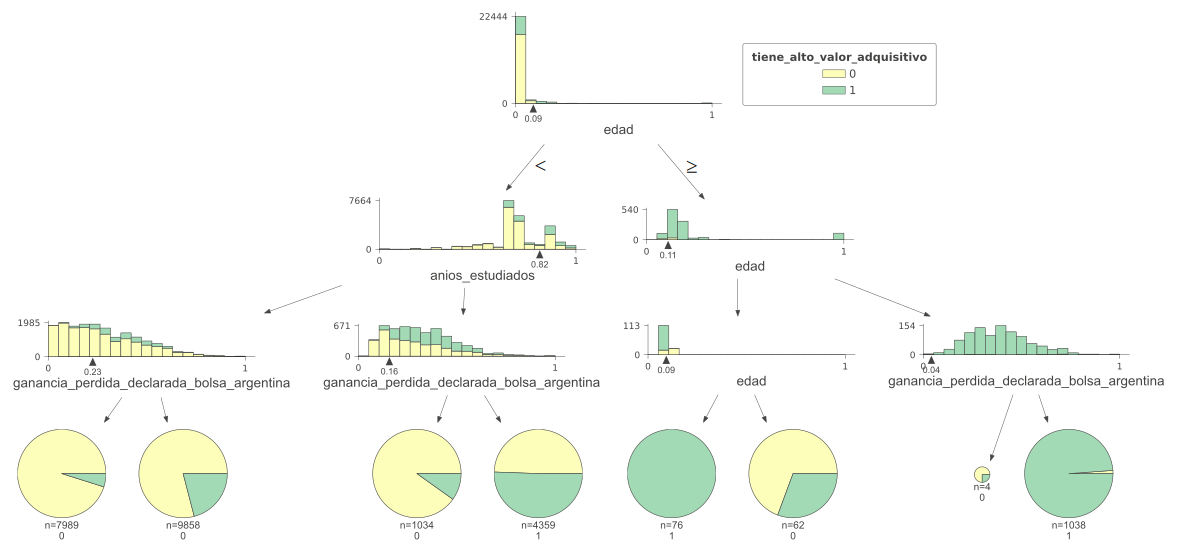

In [8]:
viz = dtreeviz.dtreeviz(
    arbol,
    X_train1,
    y_train,
    target_name='tiene_alto_valor_adquisitivo',
    feature_names=list(X.columns),
    class_names=list([0,1]),
    scale=1.5,
)

display(viz)

Se ve aquí que efectivamente se utilizan las siguientes 3 variables:
 * Edad
 * Ganancia/Pérdida declarada en la bolsa argentina
 * Años estudiados
Lo que quiere decir que, las horas trabajadas "no dividen tan bien" al espacio según el árbol de decisión.

In [9]:
def dejar_mejores_variables_continuas(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad']].copy()

In [12]:
scaler2 = MinMaxScaler(feature_range=(0,1))

X_train2 = pd.DataFrame(scaler2.fit_transform(dejar_mejores_variables_continuas(X_train)))
X_test2 = pd.DataFrame(scaler2.transform(dejar_mejores_variables_continuas(X_test)))

Veamos si TSNE nos muestra algo interesante:

In [143]:
X_tsne = TSNE(n_components=2, perplexity=200, learning_rate=100, n_iter_without_progress=250, n_jobs=-1, verbose=4).fit_transform(X_train2)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.147s...
[t-SNE] Computed neighbors for 24420 samples in 3.088s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for sa

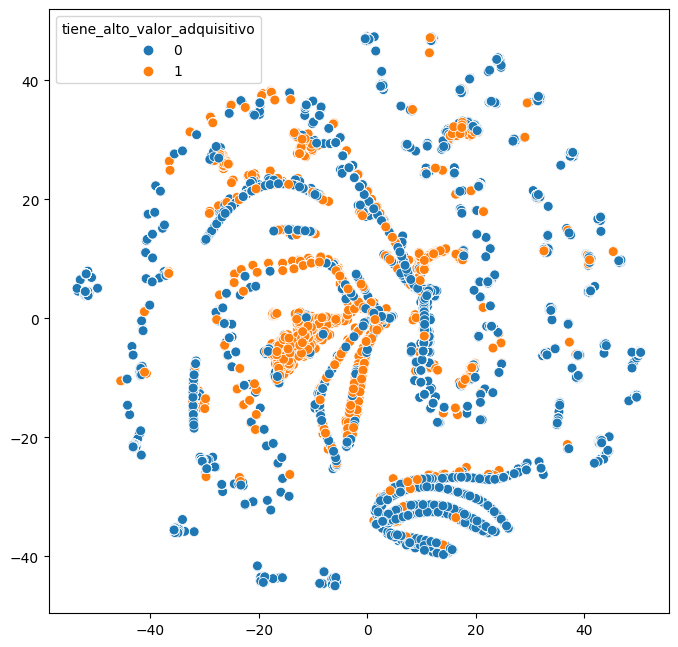

In [145]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=50
)

plt.show()

No parece haber ningún tipo de patrón visible, probablemente SVM no pueda hacer un buen trabajo...


Veamos qué ocurre si probamos con un kernel radial y uno polinómico

In [13]:
params = [{'kernel': ['poly'], 'C': np.logspace(-3, 2, 6), 'degree': range(2, 4)},
          {'kernel': ['rbf'], 'C': np.logspace(-3, 2, 6) ,'gamma': [0.01, 0.001, 0.0001]}
         ]
model = SVC()

gscv3 = GridSearchCV(model, params, scoring='roc_auc', n_jobs=6, verbose = 4, cv=4)

In [149]:
%%time
gscv3.fit(X_train2, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   25.5s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed: 10.1min finished


CPU times: user 5min 47s, sys: 387 ms, total: 5min 47s
Wall time: 15min 50s


GridSearchCV(cv=4, estimator=SVC(), n_jobs=6,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'degree': range(2, 4), 'kernel': ['poly']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='roc_auc', verbose=4)

### El mejor modelo:

In [151]:
print(gscv3.best_estimator_)
print(gscv3.best_params_)
print(gscv3.best_score_)

SVC(C=100.0, kernel='poly')
{'C': 100.0, 'degree': 3, 'kernel': 'poly'}
0.8330478708092884


Vemos que el modelo es el mismo que antes...

In [154]:
print(classification_report(y_test,gscv3.predict(X_test2)))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      6182
           1       0.87      0.25      0.39      1959

    accuracy                           0.81      8141
   macro avg       0.84      0.62      0.64      8141
weighted avg       0.82      0.81      0.77      8141



Con valores e interpretaciones similares a las anteriores.

### Veamos qué sucede si elegimos las primeras variables (no sólo continuas) que elije un árbol de decisión de altura 3. 

In [14]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth=3)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

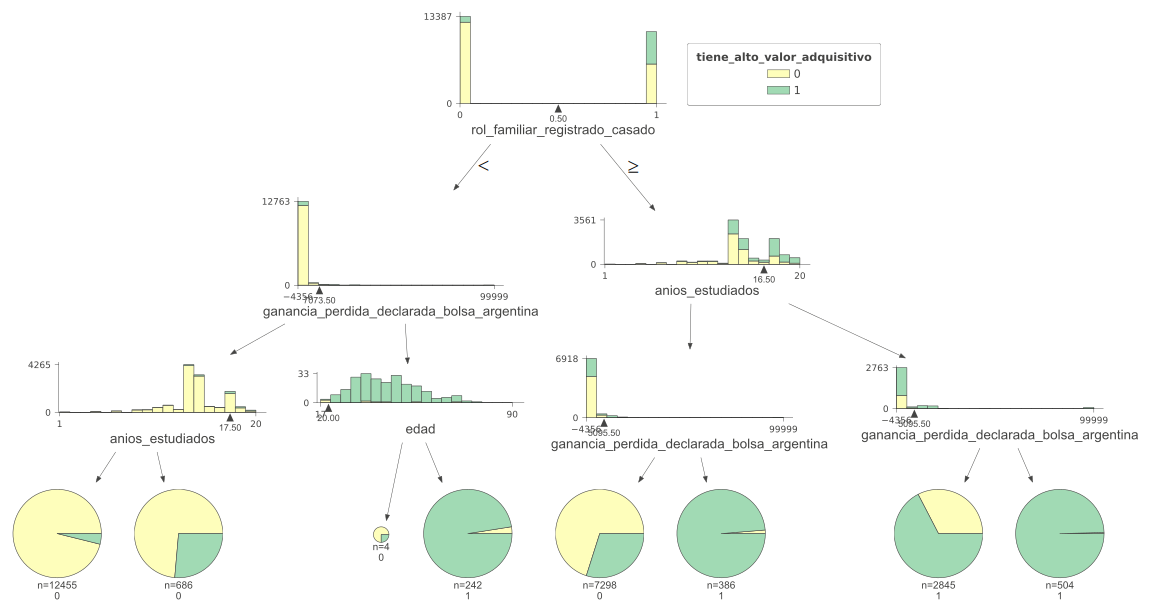

In [15]:
viz = dtreeviz.dtreeviz(
    arbol,
    X_train,
    y_train,
    target_name='tiene_alto_valor_adquisitivo',
    feature_names=list(X.columns),
    class_names=list([0,1]),
    scale=1.5,
)

display(viz)

Vemos de este árbol que las variables elegidas fueron:

* Rol familiar registrado casado
* Ganancia/Pérdida declarada en la bolsa argentina.
* Años estudiados.
* Edad

Por lo que sólo se agregó una variable (dummy) a las 3 previamente seleccionadas.


In [16]:
def primeras_4_del_arbol(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad', 'rol_familiar_registrado_casado']].copy()

In [17]:
scaler3 = MinMaxScaler(feature_range=(0,1))

X_train3 = pd.DataFrame(scaler3.fit_transform(primeras_4_del_arbol(X_train)))
X_test3 = pd.DataFrame(scaler3.transform(primeras_4_del_arbol(X_test)))

Nuevamente veamos qué nos dice TSNE

In [164]:
X_tsne = TSNE(n_components=2, perplexity=100, learning_rate=100, n_iter_without_progress=250, n_jobs=-1, verbose=4).fit_transform(X_train3)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 24420 samples in 0.160s...
[t-SNE] Computed neighbors for 24420 samples in 1.371s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24420
[t-SNE] Computed conditional probabilities for sample 2000 / 24420
[t-SNE] Computed conditional probabilities for sample 3000 / 24420
[t-SNE] Computed conditional probabilities for sample 4000 / 24420
[t-SNE] Computed conditional probabilities for sample 5000 / 24420
[t-SNE] Computed conditional probabilities for sample 6000 / 24420
[t-SNE] Computed conditional probabilities for sample 7000 / 24420
[t-SNE] Computed conditional probabilities for sample 8000 / 24420
[t-SNE] Computed conditional probabilities for sample 9000 / 24420
[t-SNE] Computed conditional probabilities for sample 10000 / 24420
[t-SNE] Computed conditional probabilities for sample 11000 / 24420
[t-SNE] Computed conditional probabilities for sample 12000 / 24420
[t-SNE] Computed conditional probabilities for sa

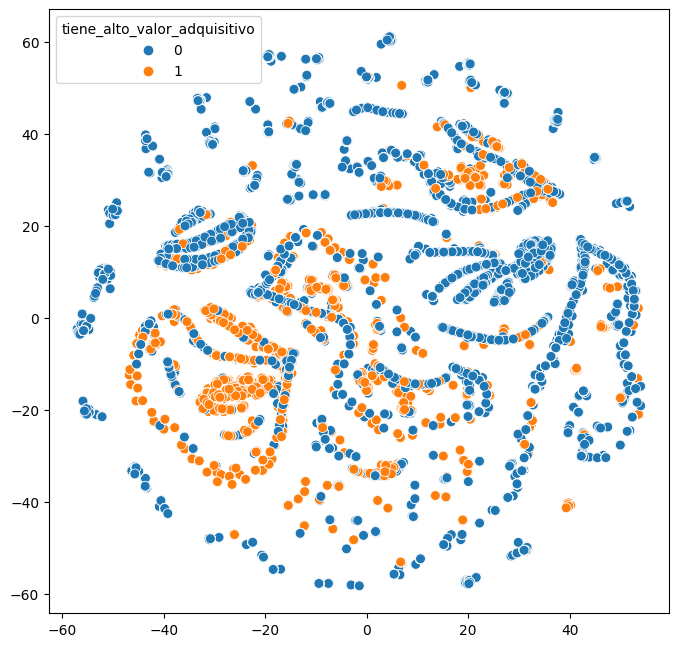

In [166]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne[:,0],
    y = X_tsne[:,1],
    hue = y_train,
    s=50
)

plt.show()

No parece haber un patrón, pero quizá algo se saca con un kernel radial.

In [18]:
params = {'kernel': ['rbf'], 'C': np.logspace(-4, 3, 8) ,'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
model = SVC()

gscv4 = GridSearchCV(model, params, scoring='accuracy', n_jobs=-1, verbose = 4, cv=4)

In [190]:
%%time
gscv4.fit(X_train3, y_train)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  5.5min finished


CPU times: user 41.5 s, sys: 309 ms, total: 41.8 s
Wall time: 6min 13s


GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=4)

In [198]:
print(gscv4.best_estimator_)
print(gscv4.best_params_)
print(gscv4.best_score_)

SVC(C=1000.0, gamma=1)
{'C': 1000.0, 'gamma': 1, 'kernel': 'rbf'}
0.8446764946764947


In [205]:
print(classification_report(y_test,gscv4.predict(X_test3)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90      6182
           1       0.75      0.51      0.61      1959

    accuracy                           0.84      8141
   macro avg       0.81      0.73      0.75      8141
weighted avg       0.83      0.84      0.83      8141



### Veamos las variables (no continuas) que usa el árbol

In [19]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth=3)
arbol.fit(X_train[X_train.columns.drop(['anios_estudiados', 'edad', 'ganancia_perdida_declarada_bolsa_argentina', 'horas_trabajo_registradas'])], y_train)

DecisionTreeClassifier(max_depth=3)

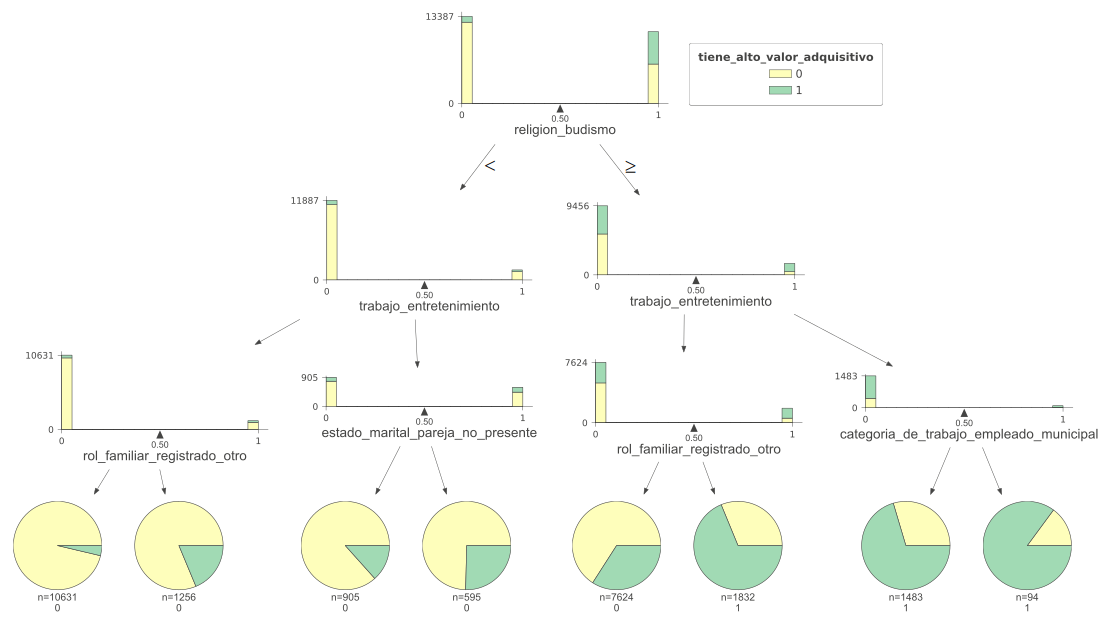

In [20]:
viz = dtreeviz.dtreeviz(
    arbol,
    X_train[X_train.columns.drop(['anios_estudiados', 'edad', 'ganancia_perdida_declarada_bolsa_argentina', 'horas_trabajo_registradas'])],
    y_train,
    target_name='tiene_alto_valor_adquisitivo',
    feature_names=list(X.columns),
    class_names=list([0,1]),
    scale=1.5,
)

display(viz)

### Variables que nos vamos a quedar

* religion_budismo
* trabajo_entretenimiento
* rol_familiar_registrado_otro


In [21]:
# La función deja las continuas que resultaron significativas para los previos árboles, la variable de 
# rol_familiar_registrado_casado pues antes también había resultado importante junto a las continuas.
# Pero además suma las 3 variables arriba mencionadas.
def quedarse_las_importantes(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad', 'rol_familiar_registrado_casado', 'religion_budismo', 
              'trabajo_entretenimiento', 'rol_familiar_registrado_otro']].copy()

In [22]:
scaler4 = MinMaxScaler(feature_range=(0,1))

X_train4 = pd.DataFrame(scaler4.fit_transform(quedarse_las_importantes(X_train)))
X_test4 = pd.DataFrame(scaler4.transform(quedarse_las_importantes(X_test)))

In [23]:
params = [{'kernel': ['linear'], 'C': np.logspace(-3, 2, 6)},
          {'kernel': ['poly'], 'C': np.logspace(-3, 2, 6), 'degree': range(2, 4)},
          {'kernel': ['rbf'], 'C': np.logspace(-3, 2, 6) ,'gamma': [0.01, 0.001, 0.0001]}
         ]
model = SVC()

gscv6 = GridSearchCV(model, params, scoring='accuracy', n_jobs=6, verbose = 4, cv=4)

In [19]:
%%time
gscv6.fit(X_train4, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   26.5s
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 144 out of 144 | elapsed:  6.1min finished


CPU times: user 1min 3s, sys: 224 ms, total: 1min 3s
Wall time: 7min 10s


GridSearchCV(cv=4, estimator=SVC(), n_jobs=6,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['linear']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'degree': range(2, 4), 'kernel': ['poly']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']}],
             scoring='accuracy', verbose=4)

In [22]:
print(gscv6.best_estimator_)
print(gscv6.best_params_)
print(gscv6.best_score_)

SVC(C=100.0, kernel='poly')
{'C': 100.0, 'degree': 3, 'kernel': 'poly'}
0.8425880425880425


In [23]:
print(classification_report(y_test,gscv6.predict(X_test4)))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      6182
           1       0.74      0.51      0.61      1959

    accuracy                           0.84      8141
   macro avg       0.80      0.73      0.75      8141
weighted avg       0.83      0.84      0.83      8141



### Conclusiones

Los modelos con SVM no parecen ser muy adecuados, sin embargo se logró obtener un accuracy similar al tp1 con este modelo... será para tener en cuenta. Sin embargo sirvió para darse una idea de cómo están distribuidos nuestros datos.
